Instalação do fastai

In [1]:
!pip install fastai --upgrade
from fastai.vision.all import *
from fastai.callback.fp16 import * 
from fastai.vision.widgets import *


     |████████████████████████████████| 188 kB 8.2 MB/s 
     |████████████████████████████████| 60 kB 6.4 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


Criação do diretório no google drive e permissão para acessar a pasta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install kaggle

Fazer upload da chave do kaggle(kaggle.json). Tutorial
 https://jovian.ai/forum/t/what-is-kaggle-api-key-how-to-get-my-kaggle-key/17721

In [4]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [45]:
!kaggle datasets download "gauravsharma99/fer13-cleaned-dataset" #pedaço do url do kaggle

fer13-cleaned-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [46]:
!unzip fer13-cleaned-dataset -d fer13

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: fer13/Neutral/Training_59186253.jpg  
  inflating: fer13/Neutral/Training_59196451.jpg  
  inflating: fer13/Neutral/Training_59207899.jpg  
  inflating: fer13/Neutral/Training_59231702.jpg  
  inflating: fer13/Neutral/Training_59239314.jpg  
  inflating: fer13/Neutral/Training_59257029.jpg  
  inflating: fer13/Neutral/Training_59262777.jpg  
  inflating: fer13/Neutral/Training_5928809.jpg  
  inflating: fer13/Neutral/Training_59297234.jpg  
  inflating: fer13/Neutral/Training_59301844.jpg  
  inflating: fer13/Neutral/Training_59316619.jpg  
  inflating: fer13/Neutral/Training_59318324.jpg  
  inflating: fer13/Neutral/Training_59349555.jpg  
  inflating: fer13/Neutral/Training_5937470.jpg  
  inflating: fer13/Neutral/Training_59384298.jpg  
  inflating: fer13/Neutral/Training_59428060.jpg  
  inflating: fer13/Neutral/Training_59432107.jpg  
  inflating: fer13/Neutral/Training_59444533.jpg  
  inflating: fer13/Neutra

In [47]:
path = Path("./fer13")

In [48]:
fns = get_image_files(path)

In [49]:
fns

(#16876) [Path('fer13/Angry/Training_24411420.jpg'),Path('fer13/Angry/Training_77040483.jpg'),Path('fer13/Angry/Training_80786945.jpg'),Path('fer13/Angry/Training_90321161.jpg'),Path('fer13/Angry/Training_57149387.jpg'),Path('fer13/Angry/Training_20763059.jpg'),Path('fer13/Angry/Training_88991541.jpg'),Path('fer13/Angry/Training_62975566.jpg'),Path('fer13/Angry/Training_97993385.jpg'),Path('fer13/Angry/Training_83471739.jpg')...]

Logo abaixo, estamos criando o `DataBlock`. Para deixar o treinamento mais rápido, está sendo utilizado a class `PILmageBW` como argumento da função `ImageBlock`, para converter as imagens em 

In [50]:
faces = DataBlock(
    blocks=(ImageBlock(cls = PILImageBW), CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms =Resize(48))

In [51]:
dls = faces.dataloaders(path)

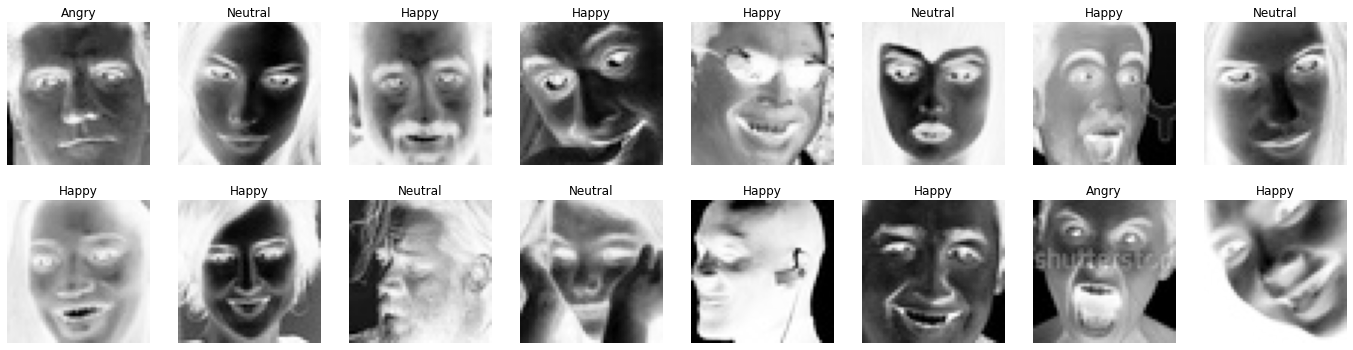

In [52]:
dls.valid.show_batch(max_n=16, nrows=2)

Tamanho do batch. 

In [53]:
x,y=dls.one_batch()
x.shape

torch.Size([64, 1, 48, 48])

Arquitetura


In [54]:
import torch.nn.functional as F


In [40]:


class Dexpression(nn.Module):
    def __init__(self, data_Channels,data_Dim, data_Features):

        super(Dexpression, self).__init__()

        # First Block
        self.conv1 = nn.Conv2d(
            in_channels=int(data_Channels), out_channels=64, kernel_size=7, stride=2, padding=3
        )
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.lrn1 = nn.LayerNorm([64, (int(data_Dim/4))-1, (int(data_Dim/4))-1])

        # Second Block
        self.conv2a = nn.Conv2d(
            in_channels=64, out_channels=96, kernel_size=1, stride=1, padding=0
        )
        self.conv2b = nn.Conv2d(
            in_channels=96, out_channels=208, kernel_size=3, stride=1, padding=1
        )
        self.pool2a = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv2c = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0
        )
        self.pool2b = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        # Third Block
        self.conv3a = nn.Conv2d(
            in_channels=272, out_channels=96, kernel_size=1, stride=1, padding=0
        )
        self.conv3b = nn.Conv2d(
            in_channels=96, out_channels=208, kernel_size=3, stride=1, padding=1
        )
        self.pool3a = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv3c = nn.Conv2d(
            in_channels=272, out_channels=64, kernel_size=1, stride=1, padding=0
        )
        self.pool3b = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)

        self.fc = nn.Linear(in_features=272 * (int(data_Dim/16)-1) * (int(data_Dim/16)-1), out_features=int(data_Features))
        self.softmax = nn.LogSoftmax(dim=1)

        self.batch_normalization = nn.BatchNorm2d(272)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x, dropout=True, batch_normalization=True):
        #relu = nn.ReLU()
        
        # First Block
        conv1_out = F.relu(self.conv1(x))
        pool1_out = self.pool1(conv1_out)
        lrn1_out = self.lrn1(pool1_out)

        # Second Block
        conv2a_out = F.relu(self.conv2a(lrn1_out))
        conv2b_out = F.relu(self.conv2b(conv2a_out))

        pool2a_out = self.pool2a(lrn1_out)
        conv2c_out = F.relu(self.conv2c(pool2a_out))

        concat2_out = torch.cat((conv2b_out, conv2c_out), 1)
        pool2b_out = self.pool2b(concat2_out)

        # Third Block
        conv3a_out = F.relu(self.conv3a(pool2b_out))
        conv3b_out = F.relu(self.conv3b(conv3a_out))

        pool3a_out = self.pool3a(pool2b_out)
        conv3c_out = F.relu(self.conv3c(pool3a_out))

        concat3_out = torch.cat((conv3b_out, conv3c_out), 1)
        pool3b_out = self.pool3b(concat3_out)

        if dropout:
            pool3b_out = self.dropout(pool3b_out)
        if batch_normalization:
            pool3b_out = self.batch_normalization(pool3b_out)


        pool3b_shape = pool3b_out.shape
        pool3b_flat = pool3b_out.reshape(
            [-1, pool3b_shape[1] * pool3b_shape[2] * pool3b_shape[3]]
        )
        

        output = self.fc(pool3b_flat)
        logits = self.softmax(output)
        """print("conv1_out ")
        print(conv1_out.shape)
        print("pool1_out ")
        print(pool1_out.shape)
        print("lrn1_out ")
        print(lrn1_out.shape)
        print("conv2a_out ")
        print(conv2a_out.shape)
        print("conv2b_out ")
        print(conv2b_out.shape)
        print("pool2a_out ")
        print(pool2a_out.shape)
        print("conv2c_out ")
        print(conv2c_out.shape)
        print("concat2_out ")
        print(concat2_out.shape)
        print("pool2b_out ")
        print(pool2b_out.shape)
        print("conv3a_out ")
        print(conv3a_out.shape)
        print("conv3b_out ") 
        print(conv3b_out.shape)
        print("pool3a_out ")
        print(pool3a_out.shape)
        print("conv3c_out ")
        print(conv3c_out.shape)
        print("concat3_out ")
        print(concat3_out.shape)
        print("pool3b_out ")
        print(pool3b_out.shape)
        print("pool3b_flat ")
        print(pool3b_flat.shape)
        print("output")
        print(output.shape)
        print("logits")
        print(logits.shape)"""

        return logits

# Treinamento do modelo

In [55]:
DexpressionArchitecture = Dexpression(1, 48, 5)

In [56]:
learn = Learner(dls, DexpressionArchitecture, metrics = accuracy, loss_func = CrossEntropyLossFlat())

In [57]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [58]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [59]:
learn.opt_func
learn.loss_func 

FlattenedLoss of CrossEntropyLoss()

SuggestedLRs(minimum=1.2022644114040304e-06, steep=1.9054606781310213e-08, valley=1.5848931980144698e-06, slide=0.0020892962347716093)

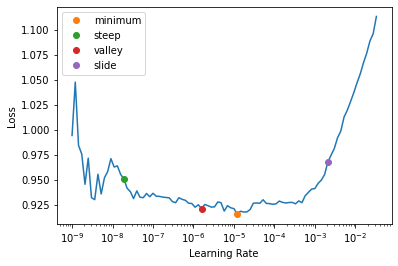

In [68]:
learn.lr_find(start_lr = 1e-9, end_lr = 1e-1, suggest_funcs=(minimum, steep, valley, slide))

In [69]:
learn.fit_one_cycle(20, 1.9054606781310213e-08)

epoch,train_loss,valid_loss,accuracy,time
0,0.921890,1.027732,0.598518,00:32
1,0.933896,1.027362,0.598518,00:31
2,0.936221,1.027983,0.599407,00:32
3,0.943641,1.027650,0.599111,00:32
4,0.929260,1.027922,0.599111,00:31
5,0.916922,1.027288,0.596444,00:31
6,0.926400,1.027141,0.597926,00:31
7,0.927795,1.026723,0.598518,00:31
8,0.908928,1.027283,0.599704,00:31
9,0.922746,1.026822,0.597630,00:31


KeyboardInterrupt: ignored

In [70]:
learn.export()

epoch,train_loss,valid_loss,accuracy,time
0,0.921890,1.027732,0.598518,00:32
1,0.933896,1.027362,0.598518,00:31
2,0.936221,1.027983,0.599407,00:32
3,0.943641,1.027650,0.599111,00:32
4,0.929260,1.027922,0.599111,00:31
5,0.916922,1.027288,0.596444,00:31
6,0.926400,1.027141,0.597926,00:31
7,0.927795,1.026723,0.598518,00:31
8,0.908928,1.027283,0.599704,00:31
9,0.922746,1.026822,0.597630,00:31


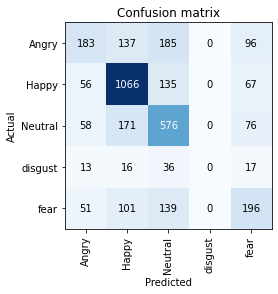

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [78]:
learn.predict('./fer13/Happy/Training_10033605.jpg')


('Happy',
 TensorImageBW(1),
 TensorImageBW([6.8395e-04, 9.9813e-01, 8.3688e-04, 1.5906e-04, 1.8820e-04]))

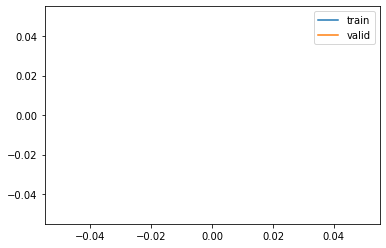

In [79]:
learn.recorder.plot_loss()

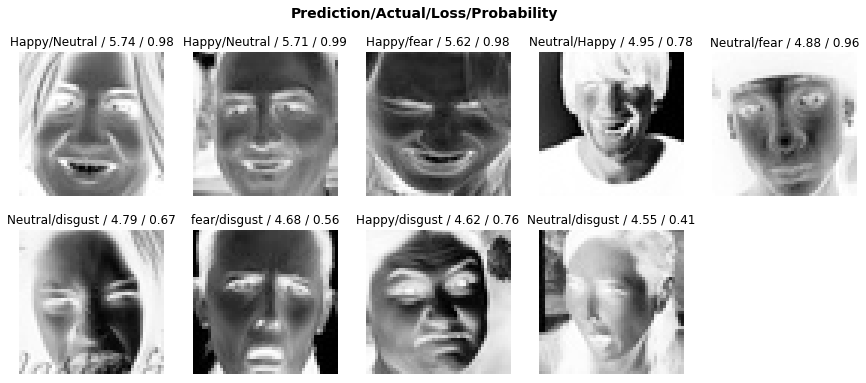

In [80]:
interp.plot_top_losses(10, nrows=2) 

In [81]:
torch.cuda.empty_cache()
